# BER & SER

## bits2symbol & compute_ser

In [53]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

def bits2symbol(bits,num_bits_per_symbol):
    # Method 1
    new_shape = [-1] + bits.shape[1:-1].as_list() + \
            [int(bits.shape[-1] / NUM_BITS_PER_SYMBOL),
                NUM_BITS_PER_SYMBOL]
    #print('new_shape =\n',new_shape)

    symbols = tf.cast(tf.reshape(bits, new_shape), tf.int32)
    #print('symbols =\n',symbols)

    # Method 2
    # symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))

    return symbols

def compute_ser(Tx_Symbols,Rx_Symbols):

    num_symbols = Tx_Symbols.shape[0] * Tx_Symbols.shape[1]
    # num_symbols = BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL)
    # print('num_symbols =',num_symbols)

    error_array = np.all(Tx_Symbols == Rx_Symbols, axis=2)
    # print('compare =\n',compare)

    error_array_reshape = np.reshape(error_array, (num_symbols, 1))
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors = np.count_nonzero(np.sum(~error_array_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser = round(num_symbol_errors/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)

    return ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
print('NUM_BITS_PER_SYMBOL =',NUM_BITS_PER_SYMBOL)
BLOCK_LENGTH = 8
print('BLOCK_LENGTH =',BLOCK_LENGTH)
BATCH_SIZE = 2 # Examples processed in parallel
print('BATCH_SIZE =',BATCH_SIZE)
EBN0_DB_MIN = -10.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

snrs = []
bers = []
sers = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
print('bits =',bits)

Tx_Symbols = bits2symbol(bits,NUM_BITS_PER_SYMBOL)
print('Tx_Symbols =',Tx_Symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,1):

    snrs += [EBN0_DB]
    print('EBN0_DB =',EBN0_DB)

    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0)
    
    x = mapper(bits)

    y = awgn_channel([x, no])

    llr = demapper([y, no])

    bits_hat = hard_decisions(llr)

    ber = compute_ber(bits, bits_hat)

    Rx_Symbols = bits2symbol(bits_hat,NUM_BITS_PER_SYMBOL)
    print('Rx_Symbols =',Rx_Symbols)

    ser = compute_ser(Tx_Symbols,Rx_Symbols)

    bers += [ber]

    sers += [ser]

print('bers =',np.transpose(bers))
print('sers =',np.transpose(sers))

NUM_BITS_PER_SYMBOL = 4
BLOCK_LENGTH = 8
BATCH_SIZE = 2
bits = tf.Tensor(
[[1. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]], shape=(2, 8), dtype=float32)
Tx_Symbols = tf.Tensor(
[[[1 1 1 1]
  [0 1 1 0]]

 [[0 0 0 0]
  [0 0 0 1]]], shape=(2, 2, 4), dtype=int32)
EBN0_DB = -10.0
Rx_Symbols = tf.Tensor(
[[[0 1 0 1]
  [0 1 0 0]]

 [[1 1 0 0]
  [1 0 0 0]]], shape=(2, 2, 4), dtype=int32)
bers = [0.4375]
sers = [1.]


## Uncoding: BER & SER

NUM_BITS_PER_SYMBOL = 4
BLOCK_LENGTH = 512
BATCH_SIZE = 1024
snrs =
 [-10.          -8.94736842  -7.89473684  -6.84210526  -5.78947368
  -4.73684211  -3.68421053  -2.63157895  -1.57894737  -0.52631579
   0.52631579   1.57894737   2.63157895   3.68421053   4.73684211
   5.78947368   6.84210526   7.89473684   8.94736842  10.        ]
bers =
 [0.36227417 0.34379387 0.32316399 0.30090523 0.27710152 0.25238609
 0.2271595  0.20206451 0.17684174 0.15316582 0.1285553  0.10660362
 0.08476067 0.06437111 0.04574966 0.03062248 0.01846504 0.00992584
 0.00473213 0.00173378]
sers =
 [0.8362 0.8199 0.7959 0.7704 0.7391 0.7048 0.664  0.6193 0.5679 0.5112
 0.4448 0.3796 0.3108 0.2411 0.1744 0.1189 0.0724 0.0393 0.0188 0.0069]


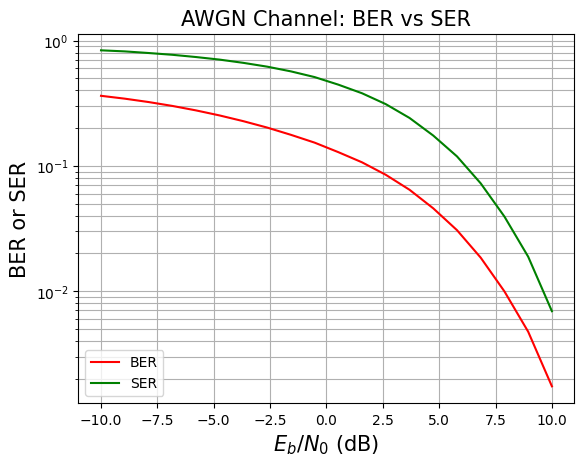

In [58]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

def bits2symbol(bits,num_bits_per_symbol):
    # Method 1
    new_shape = [-1] + bits.shape[1:-1].as_list() + \
            [int(bits.shape[-1] / NUM_BITS_PER_SYMBOL),
                NUM_BITS_PER_SYMBOL]
    #print('new_shape =\n',new_shape)

    symbols = tf.cast(tf.reshape(bits, new_shape), tf.int32)
    #print('symbols =\n',symbols)

    # Method 2
    # symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))

    return symbols

def compute_ser(Tx_Symbols,Rx_Symbols):

    num_symbols = Tx_Symbols.shape[0] * Tx_Symbols.shape[1]
    # num_symbols = BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL)
    # print('num_symbols =',num_symbols)

    error_array = np.all(Tx_Symbols == Rx_Symbols, axis=2)
    # print('compare =\n',compare)

    error_array_reshape = np.reshape(error_array, (num_symbols, 1))
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors = np.count_nonzero(np.sum(~error_array_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser = round(num_symbol_errors/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)

    return ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
print('NUM_BITS_PER_SYMBOL =',NUM_BITS_PER_SYMBOL)
BLOCK_LENGTH = 512
print('BLOCK_LENGTH =',BLOCK_LENGTH)
BATCH_SIZE = 1024 # Examples processed in parallel
print('BATCH_SIZE =',BATCH_SIZE)
EBN0_DB_MIN = -10.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary source
binary_source = sn.utils.BinarySource()

# AWGN channel
awgn_channel = sn.channel.AWGN()

snrs = []
bers = []
sers = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits =',bits)

Tx_Symbols = bits2symbol(bits,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols =',Tx_Symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0)
    
    x = mapper(bits)

    y = awgn_channel([x, no])

    llr = demapper([y, no])

    bits_hat = hard_decisions(llr)

    ber = compute_ber(bits, bits_hat)

    Rx_Symbols = bits2symbol(bits_hat,NUM_BITS_PER_SYMBOL)
    # print('Rx_Symbols =',Rx_Symbols)

    ser = compute_ser(Tx_Symbols,Rx_Symbols)

    bers += [ber]

    sers += [ser]

print('snrs =\n',np.transpose(snrs))
print('bers =\n',np.transpose(bers))
print('sers =\n',np.transpose(sers))

title = "AWGN Channel: BER vs SER"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "BER or SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers, 'r', label='BER')
plt.semilogy(snrs, sers, 'g', label='SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()

## LDPC: BER & SER

bers = [0.36338425 0.34190369 0.32386398 0.30197144 0.27576828 0.25205231
 0.22602463 0.2008667  0.17643738 0.15195847 0.12911606 0.10584259
 0.08496475 0.0650177  0.04563904 0.03119659 0.01797104 0.0098381
 0.00461578 0.00173187]
bers_LDPC = [0.43131256 0.41926575 0.40452194 0.39250183 0.37643814 0.36172485
 0.34040833 0.31948471 0.29582214 0.26980209 0.23643875 0.19620895
 0.11684799 0.02326202 0.00061798 0.         0.         0.
 0.         0.        ]
sers = [0.8369 0.8161 0.8007 0.7723 0.7385 0.7043 0.6637 0.6157 0.5654 0.5071
 0.4473 0.3777 0.3107 0.2425 0.1736 0.1203 0.0707 0.0389 0.0184 0.0069]
sers_LDPC = [0.8937 0.8829 0.871  0.8577 0.8416 0.8274 0.8054 0.7795 0.7456 0.7119
 0.6606 0.5836 0.3732 0.0764 0.0022 0.     0.     0.     0.     0.    ]


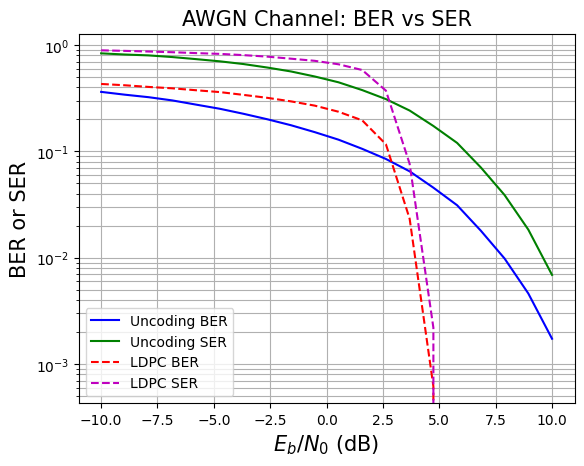

In [52]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

def bits2symbol(bits,num_bits_per_symbol):
    # Method 1
    new_shape = [-1] + bits.shape[1:-1].as_list() + \
            [int(bits.shape[-1] / NUM_BITS_PER_SYMBOL),
                NUM_BITS_PER_SYMBOL]
    #print('new_shape =\n',new_shape)

    symbols = tf.cast(tf.reshape(bits, new_shape), tf.int32)
    #print('symbols =\n',symbols)

    # Method 2
    # symbols = np.reshape(bits, (BATCH_SIZE, (BLOCK_LENGTH//NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL))

    return symbols

def compute_ser(Tx_Symbols,Rx_Symbols):

    num_symbols = Tx_Symbols.shape[0] * Tx_Symbols.shape[1]
    # num_symbols = BATCH_SIZE*(BLOCK_LENGTH//NUM_BITS_PER_SYMBOL)
    # print('num_symbols =',num_symbols)

    error_array = np.all(Tx_Symbols == Rx_Symbols, axis=2)
    # print('compare =\n',compare)

    error_array_reshape = np.reshape(error_array, (num_symbols, 1))
    # print('compare_reshape =\n',compare_reshape)

    num_symbol_errors = np.count_nonzero(np.sum(~error_array_reshape, axis=1))
    # print('num_symbol_errors =\n',num_symbol_errors)

    ser = round(num_symbol_errors/num_symbols,4)
    # print('ser_UncodedSystem =\n',ser_UncodedSystem)

    return ser

CODERATE = 0.5
n = 512
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 1024
EBN0_DB_MIN = -10.0
EBN0_DB_MAX = 10.0

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary Source
binary_source = sn.utils.BinarySource()

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# LDPC Encoder
LDPC_encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# LDPC Decoder
LDPC_decoder = sn.fec.ldpc.LDPC5GDecoder(LDPC_encoder, hard_out=True)

snrs = []
bers = []
sers = []
bers_LDPC = []
sers_LDPC = []

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
# print('bits = \n',bits)

Tx_Symbols = bits2symbol(bits,NUM_BITS_PER_SYMBOL)
# print('Tx_Symbols = \n',Tx_Symbols)

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):

    snrs += [EBN0_DB]

    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

    x = mapper(bits)

    y = awgn_channel([x, no])

    llr = demapper([y, no])

    bits_hat = hard_decisions(llr)

    ber = compute_ber(bits, bits_hat)

    Rx_Symbols = bits2symbol(bits_hat,NUM_BITS_PER_SYMBOL)

    ser = compute_ser(Tx_Symbols,Rx_Symbols)

    bers += [ber]
    sers += [ser]


    no_LDPC = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=CODERATE)

    codewords = LDPC_encoder(bits)

    x_LDPC = mapper(codewords)

    y_LDPC = awgn_channel([x_LDPC, no_LDPC])
        
    llr_LDPC = demapper([y_LDPC, no_LDPC])
        
    bits_hat_LDPC = LDPC_decoder(llr_LDPC)

    ber_LDPC = compute_ber(bits, bits_hat_LDPC)

    Rx_Symbols_LDPC = bits2symbol(bits_hat_LDPC,NUM_BITS_PER_SYMBOL)
            
    ser_LDPC = compute_ser(Tx_Symbols,Rx_Symbols_LDPC)

    bers_LDPC += [ber_LDPC]
    sers_LDPC += [ser_LDPC]

print('snrs =\n',np.transpose(snrs))
print('bers =\n',np.transpose(bers))
print('bers_LDPC =\n',np.transpose(bers_LDPC))
print('sers =\n',np.transpose(sers))
print('sers_LDPC =\n',np.transpose(sers_LDPC))

title = "AWGN Channel: BER vs SER"
xlabel = "$E_b/N_0$ (dB)"
ylabel = "BER or SER"
plt.title(title, fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.grid(which="both")
plt.semilogy(snrs, bers, 'b', label='Uncoding BER')
plt.semilogy(snrs, sers, 'g', label='Uncoding SER')
plt.semilogy(snrs, bers_LDPC, 'r--', label='LDPC BER')
plt.semilogy(snrs, sers_LDPC, 'm--', label='LDPC SER')
plt.legend(loc='lower left', fontsize=10)
plt.show()